# Random Forest Classification
This exercise uses the Wisconsin breast cancer dataset (https://archive.ics.uci.edu/dataset/17/breast+cancer+wisconsin+diagnostic). Features are computed from a digitized image of a fine needle aspirate of a breast mass. They describe characteristics of the cell nuclei present in the image. 

Use a Random Forest Classifier for a binary classification (benign vs. malignant).

#### Preparation

Load libraries and dataset (via sklearn for convenience)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score,
    roc_auc_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
    RocCurveDisplay
)

Load and inspect the data. Is the dataset balanced?

In [2]:
data = load_breast_cancer()

X = pd.DataFrame(data.data, columns=data.feature_names)

# Convert numeric labels to meaningful class names
y = pd.Series(data.target).map({0: "Malignant", 1: "Benign"})

print("Feature matrix shape:", X.shape)
print("\nClass distribution:")
print(y.value_counts())

Feature matrix shape: (569, 30)

Class distribution:
Benign       357
Malignant    212
Name: count, dtype: int64


In [10]:
X.duplicated().any()

np.False_

Train/test split: Test later how your predictions change if you don't use stratify.

In [11]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.3,
    random_state=42,
    stratify=y #ensures similarity of class proportions in test and training data
)

#### Default RF model
Note that the RF's predictions are probabilities for a data point to be in a certain class (this is, what `predict_proba()` delivers). The threshold for predicting labels with `predict()` is 50%. 

Is 50% a good choice? You can try a different threshold like so:\
`y_scores = best_rf.predict_proba(X_test)[:, 1]`\
`threshold = 0.3`\
`y_pred_custom = np.where(y_scores > threshold, "Benign", "Malignant")`\
`confusion_matrix(y_test, y_pred_custom)`\

In [12]:
rf_default = RandomForestClassifier(random_state=42)

rf_default.fit(X_train, y_train)

y_pred = rf_default.predict(X_test) # based on the probability (threshold 50%)
y_proba = rf_default.predict_proba(X_test)[:, 1] # the probabilities for a positive (needed for the ROC-AUC score)

Evaluation of the model's performance: ROC-AUC is the metric for binary classification, accuracy simply determines how many of the predictions were correct

In [14]:
print("Baseline Accuracy:", accuracy_score(y_test, y_pred))
print("Baseline ROC-AUC score:", roc_auc_score(y_test, y_proba))

Baseline Accuracy: 0.9649122807017544
Baseline ROC-AUC score: 0.9967873831775701


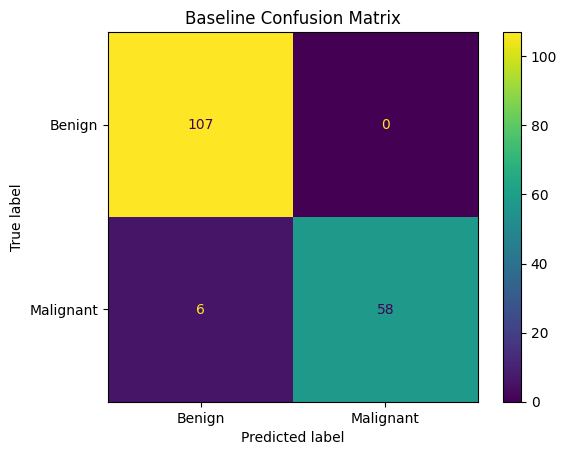

In [15]:
ConfusionMatrixDisplay.from_estimator(rf_default, X_test, y_test)
plt.title("Baseline Confusion Matrix")
plt.show()

Demo: Cross validation matters. There is a difference between the splits.

In [16]:
cv_scores = cross_val_score(
    rf_default,
    X_train,
    y_train,
    cv=5,
    scoring="roc_auc"
)

print("CV ROC-AUC scores:", cv_scores)
print("Mean CV ROC-AUC:", np.mean(cv_scores))

CV ROC-AUC scores: [0.99933333 1.         0.98233333 0.9962069  0.95275862]
Mean CV ROC-AUC: 0.9861264367816093


#### Hyperparameter tuning: Grid Search
Using defined parameters, a Grid Search is performed. Not all hyperparameters of the model have been chosen for this (to save some time), and a limited number of options is given for each. You can play around with the values later and see how they impact the performance of the RF.

Some notes on the selected parameters:
- `n_estimators`: Number of trees. Too small: unstable!
- `max_depth`: Tree complexity. Too deep: overfitting! None = grow until pure.
- `min_samples_leaf`: Regularisation (prevents very specific splits). Larger = Smoother
- `max_features`: Feature randomness for each split, controls correlation. Too large (None): trees similar, correlated features dominate.

Simultaneous the GridSearchCV is simultaneously doing a CV and using the scores of that for the evaluation of the hyperparameters.

In [18]:
param_grid = {
    "n_estimators": [100, 300],
    "max_depth": [None, 5, 10],
    "min_samples_leaf": [1, 3],
    "max_features": ["sqrt", 0.5]
}

In [19]:
rf = RandomForestClassifier(random_state=42)

grid = GridSearchCV(
    rf,
    param_grid,
    cv=5,
    scoring="roc_auc",
    n_jobs=-1
)

grid.fit(X_train, y_train)

print("Best parameters:", grid.best_params_)
print("Best CV ROC-AUC:", grid.best_score_)

Best parameters: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'n_estimators': 300}
Best CV ROC-AUC: 0.9870988505747127


Predict using the best estimator and evaluate the performance.

In [20]:
best_rf = grid.best_estimator_

y_pred_tuned = best_rf.predict(X_test)
y_proba_tuned = best_rf.predict_proba(X_test)[:, 1]

print("Tuned Accuracy:", accuracy_score(y_test, y_pred_tuned))
print("Tuned ROC-AUC:", roc_auc_score(y_test, y_proba_tuned))

Tuned Accuracy: 0.9766081871345029
Tuned ROC-AUC: 0.9963492990654206


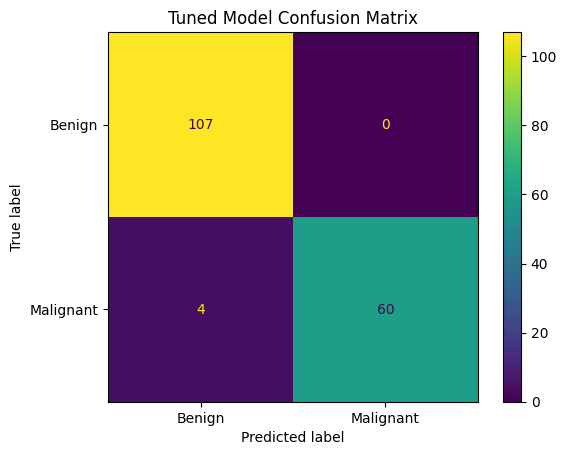

In [21]:
ConfusionMatrixDisplay.from_estimator(best_rf, X_test, y_test)
plt.title("Tuned Model Confusion Matrix")
plt.show()

##### Discussion
- What is your take on the performance improvement? is this a relevant improvement?
- Could the "best" model also be worse? 
- Was the improvement clinically relevant?
- How important is accuracy in this context? 
- What could you to to improve on the false negatives? 

#### Feature importance

See which features dominate the RF model!

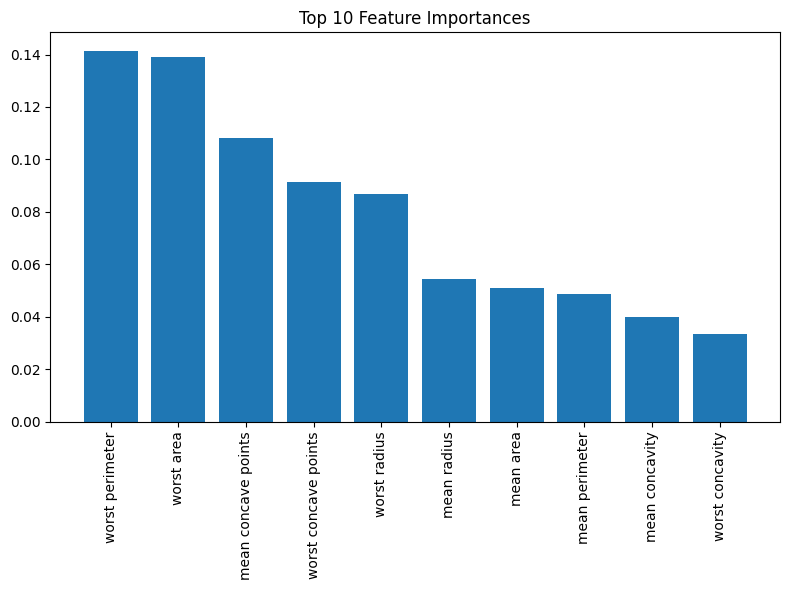

In [22]:
importances = best_rf.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(8, 6))
plt.bar(range(10), importances[indices][:10])
plt.xticks(range(10), X.columns[indices][:10], rotation=90)
plt.title("Top 10 Feature Importances")
plt.tight_layout()
plt.show()